IMPORTING NECESSARY LIBRARIES

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

LOADING AND PRE PROCESSING THE DATA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import zipfile

import zipfile
import os

# Define the path to the zip file in your Google Drive
zip_path = '/content/drive/My Drive/archive.zip'

# Define the extraction path
extract_path = '/content/'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List the contents of the extraction directory
extracted_files = os.listdir(extract_path)
print(extracted_files)



Mounted at /content/drive
['.config', 'Model', 'drive', 'dataset', 'test', 'sample_data']


In [ ]:
train_data_dir = '/content/dataset/Dataset/train'
val_data_dir = '/content/dataset/Dataset/val'


Define the ImageDataGenerator for data augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1. / 255)


Define image size and batch size

In [ ]:
img_width, img_height = 299, 299
batch_size = 32



Load training and validation data using flow_from_directory method

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


Found 3996 images belonging to 20 classes.
Found 1250 images belonging to 20 classes.


 Build and train the food classification model

In [ ]:
# Number of classes
n_classes = len(train_generator.class_indices)

# Load InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add custom layers on top of InceptionV3
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(n_classes, activation='softmax')(x)

# Create model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator,
          steps_per_epoch=train_generator.samples // batch_size,
          validation_data=val_generator,
          validation_steps=val_generator.samples // batch_size,
          epochs=5)

# Save the model
model.save('food_classification_model.h5')

87910968/87910968 [==============================] - 2s 0us/step


Epoch 1/5
124/124 [==============================] - 176s 1s/step - loss: 1.4282 - accuracy: 0.5908 - val_loss: 0.7804 - val_accuracy: 0.7780
Epoch 2/5
124/124 [==============================] - 163s 1s/step - loss: 0.6580 - accuracy: 0.8005 - val_loss: 0.5205 - val_accuracy: 0.8478
Epoch 3/5
124/124 [==============================] - 164s 1s/step - loss: 0.5367 - accuracy: 0.8355 - val_loss: 0.4396 - val_accuracy: 0.8718
Epoch 4/5
124/124 [==============================] - 160s 1s/step - loss: 0.4560 - accuracy: 0.8580 - val_loss: 0.4586 - val_accuracy: 0.8574
Epoch 5/5
124/124 [==============================] - 181s 1s/step - loss: 0.3896 - accuracy: 0.8731 - val_loss: 0.4124 - val_accuracy: 0.8694


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Load the nutritional data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
xlsx_path = '/content/drive/My Drive/food_calorie.xlsx'
# Read the XLSX file into a DataFrame
df = pd.read_excel(xlsx_path)

# Now you can work with the DataFrame
print(df.head())  # Display the first few rows of the DataFrame


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
          Burger  250  20  15  15.1
0    Butter Naan  320  40   8  15.0
1           Chai   50   5   2   3.0
2        Chapati   70  15   2   0.5
3  Chole Bhature  320  30  10  18.0
4    Dal Makhani  150  10   5  10.0


Define functions to predict food and estimate nutritional information

In [ ]:
def predict_food(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.
    prediction = model.predict(img)
    return prediction

def estimate_nutritional_info(prediction, nutritional_data):
    predicted_class = np.argmax(prediction)
    predicted_food = list(train_generator.class_indices.keys())[predicted_class]
    nutritional_info = nutritional_data[nutritional_data.iloc[:, 0].str.lower() == predicted_food.lower()]
    return nutritional_info.values.tolist()[0] if not nutritional_info.empty else None


Define a function to display predicted food and its nutritional information

In [ ]:
def display_food_and_nutrition(image_path, predicted_food, nutritional_info):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    display(img)
    print("Predicted Food:", predicted_food)
    if nutritional_info is not None:
        print("Food:", nutritional_info[0])
        print("Calories:", nutritional_info[1],"Kcal")
        print("Carbohydrates:", nutritional_info[2],"g")
        print("Proteins:", nutritional_info[3],"g")
        print("Fats:", nutritional_info[4],"g")
    else:
        print("No nutritional information found for", predicted_food)

Use the functions to predict food and estimate nutritional information

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['.config', 'Model', 'drive', 'food_classification_model.h5', 'dataset', 'test', 'sample_data']
Available food categories:
['samosa', 'burger', 'butter_naan', 'chole_bhature', 'fried_rice', 'dal_makhani', 'paani_puri', 'idli', 'chai', 'kaathi_rolls', 'dhokla', 'momos', 'masala_dosa', 'kulfi', 'pizza', 'kadai_paneer', 'pakode', 'chapati', 'pav_bhaji', 'jalebi']
Enter the name of the food category you want to predict: chapati
1/1 [==============================] - 0s 27ms/step
Predicted food: chapati


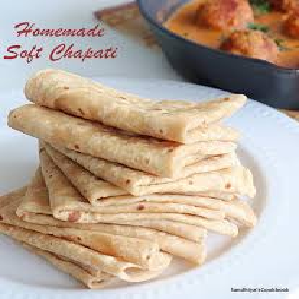

Predicted Food: chapati
Food: Chapati
Calories: 70 Kcal
Carbohydrates: 15 g
Proteins: 2 g
Fats: 0.5 g


In [ ]:

from google.colab import drive
drive.mount('/content/drive')
# Define the path to the zip file in your Google Drive
zip_path = '/content/drive/My Drive/archive.zip'

# Define the extraction path
extract_path = '/content/'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List the contents of the extraction directory
extracted_files = os.listdir(extract_path)
print(extracted_files)

import os
import random

# Define the path to the test directory
test_dir = '/content/test'

# List all available food categories
food_categories = os.listdir(test_dir)
print("Available food categories:")
print(food_categories)

# Let the user choose a food category
chosen_category = input("Enter the name of the food category you want to predict: ")

# Check if the chosen category is valid
if chosen_category in food_categories:
    # Get a list of image files in the chosen category
    category_dir = os.path.join(test_dir, chosen_category)
    image_files = [os.path.join(category_dir, image_name)
                   for image_name in os.listdir(category_dir)
                   if os.path.isfile(os.path.join(category_dir, image_name))]

    # Choose a random image file from the chosen category
    random_image = random.choice(image_files)

    # Perform prediction on the randomly selected image
    prediction = predict_food(random_image)

    # Display the predicted food
    print("Predicted food:", chosen_category)

    # Estimate nutritional information
    if chosen_category.lower() in df.iloc[:, 0].str.lower().values:
        nutritional_info = estimate_nutritional_info(prediction, df)
    else:
        nutritional_info = None

    # Display the predicted food and its nutritional information
    display_food_and_nutrition(random_image, chosen_category, nutritional_info)

else:
    print("Invalid food category. Please choose from the available categories.")